In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
 !pip install tensorflow-addons

In [1]:


%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')
pd.set_option("display.max_columns", None)



2.4.0 2.4.1


18632
Index(['image', 'labels'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


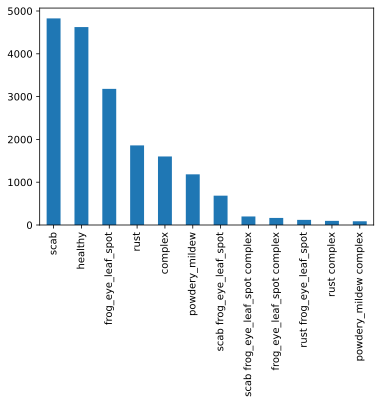

In [3]:
train = pd.read_csv(r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\train.csv')
print(len(train))
print(train.columns)
# print(train['labels'].value_counts())
print(train['labels'].value_counts().plot.bar())

In [4]:

train['labels'] = train['labels'].apply(lambda string: string.split(' '))




Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

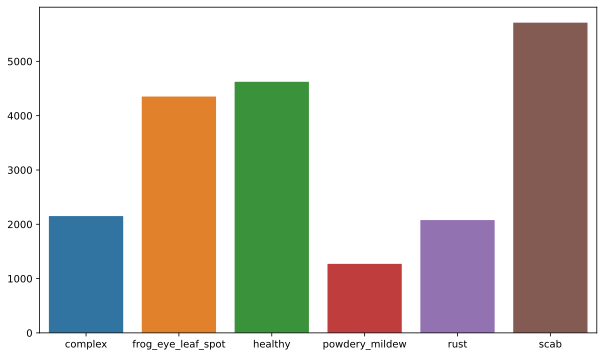

In [5]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

In [6]:
train_dir = r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\train_images'

def add_gauss_noise(X, sigma2=0.1):  #0.05
    # add Gaussian noise with zero mean, and variance sigma2
    return X + np.random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
    validation_split=0.1
)
bsize = 16

train_data = datagen.flow_from_dataframe(
    train,
    directory=train_dir,
    x_col="image",
    y_col= 'labels',
    subset="training",
    color_mode="rgb",
    target_size = (224,224),
    class_mode="categorical",
    batch_size=bsize,
    shuffle=False,
    seed=40,
)
valid_data = datagen.flow_from_dataframe(
    train,
    directory=train_dir,
    x_col="image",
    y_col= 'labels',
    subset="validation",
    color_mode="rgb",
    target_size = (224,224),
    class_mode="categorical",
    batch_size=bsize,
    shuffle=False,
    seed=40,
)

Found 16769 validated image filenames belonging to 6 classes.
Found 1863 validated image filenames belonging to 6 classes.


In [7]:
accname = 'f1_score'

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training f1_score ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_'+accname], 'b--', label="validation f1_score ({:.4f})".format(history.history['val_'+accname][-1]))

        ax2.legend(loc="lower right", fontsize=9)
        ax2.set_ylabel('acc', color='b')  

In [9]:
# import tensorflow.keras.applications.resnet50 as resnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB3
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# create the base pre-trained model with-out the classifier
# using global average pooling
weight_path = r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = tf.keras.applications.InceptionV3(weights=weight_path, include_top=False, pooling='avg')

# start with the output of the ResNet50 (1x1x2048) 
x = base_model.output

# # fully-connected layer 
# x = Dense(128, activation='relu')(x)
# # fully-connected layer 
# x = Dense(64, activation='relu')(x)
# # fully-connected layer 
x = Dense(16, activation='relu')(x)
# finally, the softmax for the classifier 
predictions = Dense(6, activation='sigmoid')(x)

C:\Users\aruve\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1049/1049 [==============================] - 3507s 3s/step - loss: 0.2537 - f1_score: 0.6415 - val_loss: 0.1521 - val_f1_score: 0.8029
Epoch 2/10
1049/1049 [==============================] - 3718s 4s/step - loss: 0.1274 - f1_score: 0.8332 - val_loss: 0.1302 - val_f1_score: 0.8461
Epoch 3/10
1049/1049 [==============================] - 3523s 3s/step - loss: 0.1007 - f1_score: 0.8634 - val_loss: 0.1106 - val_f1_score: 0.8388
Epoch 4/10
1049/1049 [==============================] - 3707s 4s/step - loss: 0.0787 - f1_score: 0.8863 - val_loss: 0.1085 - val_f1_score: 0.8427
Epoch 5/10
1049/1049 [==============================] - 3389s 3s/step - loss: 0.0681 - f1_score: 0.9009 - val_loss: 0.1350 - val_f1_score: 0.8423
Epoch 6/10
1049/1049 [==============================] - 3378s 3s/step - loss: 0.0610 - f1_score: 0.9150 - val_loss: 0.1133 - val_f1_score: 0.8667
Epoch 7/10
1049/1049 [==============================] - 3852s 4s/step - loss: 0.0535 - f1_score: 0.9204 - val_loss: 0.1024 -

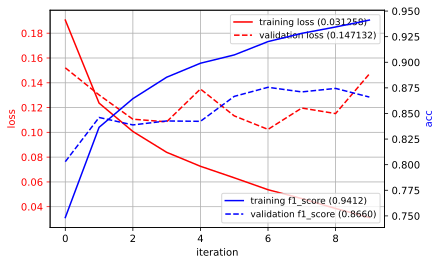

In [10]:
# build the model for training
# - need to specify the input layer and the output layer
model_ft = Model(inputs=base_model.input, outputs=predictions)

# # fix the layers of the ResNet50.
# for layer in base_model.layers:
#     layer.trainable = False

f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

# compile the model - only the layers that we added will be trained
model_ft.compile(optimizer=keras.optimizers.SGD(lr=0.03, 
                                decay=1e-4,  # decay LR each iteration (batch) 
                                momentum=0.8, nesterov=True), 
              loss='binary_crossentropy', metrics=[f1])
# model_ft.compile(optimizer=keras.optimizers.Adam(lr=0.03), 
#               loss='binary_crossentropy', metrics=[f1])

# setup early stopping callback function
accearlystop = keras.callbacks.EarlyStopping(
    monitor=f1,     # look at the validation loss tf2.0 accuracy
    min_delta=0.02,       # threshold to consider as no change
    patience=5,             # stop if  epochs with no change
    verbose=1, mode='max', restore_best_weights= True
)
lossearlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss tf2.0 accuracy
    min_delta=0.02,       # threshold to consider as no change
    patience=5,             # stop if  epochs with no change
    verbose=1, mode='min', restore_best_weights= True
)
# callbacks_list = [earlystop]
lrschedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.05, patience=5, verbose=1)
# callbacks_list = [lrschedule,accearlystop,lossearlystop]
# callbacks_list = [accearlystop,lossearlystop]
callbacks_list = []


# train the model on the new data for a few epochs
STEP_SIZE_TRAIN=train_data.n
STEP_SIZE_VALID=valid_data.n
history = model_ft.fit_generator(
            train_data,  # data from generator
#             steps_per_epoch=1,    # should be number of batches per epoch
            epochs=10,
            callbacks=callbacks_list, 
            validation_data=valid_data, 
#             validation_steps = 1,
            verbose=True)

plot_history(history)